<a href="https://colab.research.google.com/github/ericleo8/Wine-Reviews-Analysis/blob/main/Wine_Reviews_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
df = pd.read_csv(r"drive/MyDrive/Colab Notebooks/Wine Reviews/wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df = df.dropna(subset=["description", "points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


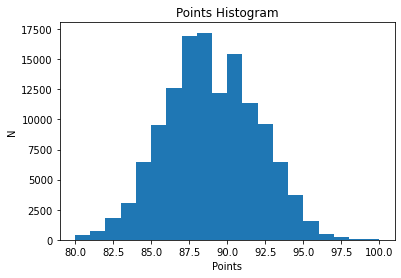

In [ ]:
plt.hist(df.points, bins=20)
plt.title("Points Histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [ ]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [ ]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.53250057,  0.18199888,  0.02638042, ...,  0.05926199,
        -0.15215334, -0.11271246],
       [ 0.49569726, -0.24339366,  0.13143642, ...,  0.02441179,
        -0.26759768,  0.02025296],
       [ 0.23021197,  0.27644882,  0.02821933, ..., -0.24534868,
        -0.1677693 ,  0.09262993],
       ...,
       [ 0.63380206,  0.06872325,  0.20439787, ..., -0.0557454 ,
        -0.22339632, -0.02947278],
       [ 0.7510908 , -0.0828253 ,  0.1245032 , ..., -0.134472  ,
        -0.21998876,  0.17420611],
       [ 0.27610984, -0.17153521,  0.02711516, ..., -0.20323822,
        -0.13428868,  0.19045855]], dtype=float32)>

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 1s 10ms/step - loss: 0.7065 - accuracy: 0.4020


[0.7065386772155762, 0.4019581377506256]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 0s 10ms/step - loss: 0.7066 - accuracy: 0.4039


[0.7066410779953003, 0.4039393663406372]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 54s 524ms/step - loss: 0.6285 - accuracy: 0.6405 - val_loss: 0.4897 - val_accuracy: 0.7905
Epoch 2/5
102/102 [==============================] - 55s 535ms/step - loss: 0.4653 - accuracy: 0.7860 - val_loss: 0.3902 - val_accuracy: 0.8201
Epoch 3/5
102/102 [==============================] - 54s 529ms/step - loss: 0.3968 - accuracy: 0.8267 - val_loss: 0.3699 - val_accuracy: 0.8301
Epoch 4/5
102/102 [==============================] - 54s 527ms/step - loss: 0.3630 - accuracy: 0.8462 - val_loss: 0.3638 - val_accuracy: 0.8340
Epoch 5/5
102/102 [==============================] - 56s 549ms/step - loss: 0.3384 - accuracy: 0.8578 - val_loss: 0.3621 - val_accuracy: 0.8367


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 1s 69ms/step - loss: 0.3750 - accuracy: 0.8310


[0.3750057816505432, 0.8309739828109741]

In [ ]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 156ms/step - loss: 0.6932 - accuracy: 0.4909


[0.6932046413421631, 0.4908825159072876]

In [ ]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 49s 437ms/step - loss: 0.5500 - accuracy: 0.7084 - val_loss: 0.3803 - val_accuracy: 0.8233
Epoch 2/5
102/102 [==============================] - 45s 443ms/step - loss: 0.3743 - accuracy: 0.8333 - val_loss: 0.3486 - val_accuracy: 0.8415
Epoch 3/5
102/102 [==============================] - 44s 430ms/step - loss: 0.3504 - accuracy: 0.8451 - val_loss: 0.3470 - val_accuracy: 0.8410
Epoch 4/5
102/102 [==============================] - 44s 434ms/step - loss: 0.3419 - accuracy: 0.8486 - val_loss: 0.3439 - val_accuracy: 0.8407
Epoch 5/5
102/102 [==============================] - 47s 462ms/step - loss: 0.3373 - accuracy: 0.8505 - val_loss: 0.3451 - val_accuracy: 0.8417


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 4s 297ms/step - loss: 0.3452 - accuracy: 0.8416


[0.34517520666122437, 0.8415910005569458]